<a href="https://colab.research.google.com/github/basselkassem/nlp-toolkit/blob/master/image_caption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt encoder-decoder-with-attention](https://miro.medium.com/max/511/1*qhOlQHLdtfZORIXYuoCtaA.png) 

source: https://towardsdatascience.com/sequence-2-sequence-model-with-attention-mechanism-9e9ca2a613a

# Download Data

In [2]:
!wget http://images.cocodataset.org/zips/train2014.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip

--2020-08-09 21:00:23--  http://images.cocodataset.org/zips/train2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.139.43
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.139.43|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13510573713 (13G) [application/zip]
Saving to: ‘train2014.zip’

train2014.zip       100%[===================>]  12.58G  35.2MB/s    in 6m 39s  

2020-08-09 21:07:03 (32.3 MB/s) - ‘train2014.zip’ saved [13510573713/13510573713]

--2020-08-09 21:07:04--  http://images.cocodataset.org/annotations/annotations_trainval2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.170.227
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.170.227|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252872794 (241M) [application/zip]
Saving to: ‘annotations_trainval2014.zip’

annotations_trainva 100%[===================>] 241.16M  35.1MB/s    in 7.5

In [3]:
!ls

annotations_trainval2014.zip  sample_data  train2014.zip


In [4]:
%%time
from zipfile import ZipFile
with ZipFile('annotations_trainval2014.zip') as ref_file:
  ref_file.extractall()

CPU times: user 5.51 s, sys: 744 ms, total: 6.25 s
Wall time: 6.41 s


In [5]:
%%time
with ZipFile('train2014.zip') as ref_file:
  ref_file.extractall()

CPU times: user 30.6 s, sys: 23.5 s, total: 54.1 s
Wall time: 6min 24s


In [6]:
!ls annotations

captions_train2014.json   instances_val2014.json
captions_val2014.json	  person_keypoints_train2014.json
instances_train2014.json  person_keypoints_val2014.json


# Import Libs

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import time
from PIL import Image
%matplotlib inline

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Dense, Embedding, GRU
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.train import Checkpoint, CheckpointManager

from tensorflow.keras.applications import InceptionV3, inception_v3

print(tf.__version__)

2.3.0


# Prepare Data

In [10]:
image_folder = 'train2014/'
annotation_file = 'annotations/captions_train2014.json'

with open(annotation_file) as ref_file:
  annotations = json.load(ref_file)
annotations = annotations['annotations']

In [23]:
SAMPLES_NUM = 30000
captions_list = np.random.choice(annotations, size = SAMPLES_NUM)

In [24]:
def get_img_name(img_id):
  return 'COCO_train2014_{:012d}.jpg'.format(img_id)

captions, image_paths = [], []
for caption_item in captions_list:
  img_path = image_folder + get_img_name(caption_item['image_id'])
  image_paths.append(img_path)
  captions.append(caption_item['caption'])

# Data Processing

## Image Feature Extraction

In [25]:
def process_image(img):
  res_img = tf.image.resize(img, size =(299, 299))
  return inception_v3.preprocess_input(res_img)

def read_image(img_path):
  img = tf.io.read_file(img_path)
  img = tf.image.decode_jpeg(img, channels = 3)
  return process_image(img), img_path

def create_feature_extractor():
  model = InceptionV3(include_top=False, weights = 'imagenet')
  input = model.input
  output = model.layers[-1].output
  feature_extractor = Model(inputs = input, outputs = output)
  return feature_extractor

feature_extractor = create_feature_extractor()

Load the images, extract features using inception_v3 and save the results on the desk. The reasons of doing this are: 
*  Use tensorflow parallel computing abilities to load the images
*  Reduce the amount of computations required during training by extracting features from images at early stage


In [26]:
unique_image_paths = sorted(set(image_paths))
image_ds = tf.data.Dataset.from_tensor_slices(unique_image_paths)
image_ds = image_ds.map(
    read_image, num_parallel_calls = tf.data.experimental.AUTOTUNE
).batch(32)

for imgs_batch, path_batch in image_ds:
  img_features_batch = feature_extractor(imgs_batch)
  img_features_batch = tf.reshape(img_features_batch, shape = (
      img_features_batch.shape[0], img_features_batch.shape[1] * img_features_batch.shape[2], -1,
  ))

  for img_features, path in zip(img_features_batch, path_batch):
    img_path = path.numpy().decode('utf-8')
    np.save(img_path, img_features)

##Caption Preprocessing

In [27]:
captions = ['<start> ' + caption + ' <end>' for caption in captions]

In [28]:
words_num = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words = words_num,
    filters = '!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ',
    oov_token = '<unk>',
)
tokenizer.fit_on_texts(captions)
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

captions_seqs = tokenizer.texts_to_sequences(captions)
captions_seqs = tf.keras.preprocessing.sequence.pad_sequences(
    captions_seqs, 
    padding = 'post',
)

## Creating Train/Test Datasets

In [29]:
img_paths_tr, img_paths_val, captions_seqs_tr, captions_seqs_val = train_test_split(
    image_paths, captions_seqs, train_size = 0.8,
)
len(img_paths_tr), len(img_paths_val), len(captions_seqs_tr), len(captions_seqs_val)

(24000, 6000, 24000, 6000)

In [30]:
BATCH_SIZE = 64
VOCAB_SIZE = words_num + 1
BUFFER_SIZE = 1000

def load_img_features(img_path, caption):
  path = img_path.decode('utf-8') + '.npy'
  return np.load(path), caption

train_ds = tf.data.Dataset.from_tensor_slices((img_paths_tr, captions_seqs_tr))
train_ds = train_ds.map(
    lambda img_path, caption: tf.numpy_function(
      load_img_features,  [img_path, caption], [tf.float32, tf.int32],  
    ),
    num_parallel_calls = tf.data.experimental.AUTOTUNE,
)

train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_ds = train_ds.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)

In [31]:
sample_img_batch, sample_cap_batch = next(iter(train_ds))
sample_img_batch.shape, sample_cap_batch.shape

(TensorShape([64, 64, 2048]), TensorShape([64, 47]))

# Build the Model

## Attention Mechanisim

In [37]:
class Attention(Model):
  def __init__(self, units):
    super(Attention, self).__init__()
    self.W1 = Dense(units)
    self.W2 = Dense(units)
    self.V = Dense(1)

  def call(self, img_features, hidden_state):
    hidden_state = tf.expand_dims(hidden_state, 1)
    score = tf.nn.tanh(self.W1(img_features) + self.W2(hidden_state))
    score = self.V(score)
    attention_weights = tf.nn.softmax(score, axis = 1)
    context = attention_weights * img_features
    context = tf.reduce_mean(context, axis=1)
    return context, attention_weights

atten = Attention(20)
hstate = tf.random.uniform(shape = [64, 30])
context, attention_weights = atten(sample_img_batch, hstate)
context.shape, attention_weights.shape

(TensorShape([64, 2048]), TensorShape([64, 64, 1]))

## CNN Encoder

In [38]:
class CNNEncoder(Model):
  def __init__(self, units):
    super(CNNEncoder, self).__init__()
    self.fc = Dense(units)

  def call(self, x):
    y = self.fc(x)
    y = tf.nn.relu(y)
    return y

encoder = CNNEncoder(10)
sample_enc_output = encoder(sample_img_batch)
sample_enc_output.shape

TensorShape([64, 64, 10])

## RNN Decoder

In [50]:
class RNNDecoder(Model):
  def __init__(self, units, vocab_size, embedding_size,):
    super(RNNDecoder, self).__init__()
    self.units = units
    self.embedding = Embedding(vocab_size, embedding_size)
    self.gru = GRU(
        units,
        return_state = True,
        return_sequences = True,
        recurrent_initializer = 'glorot_uniform',
    )
    self.fc1 = Dense(units)
    self.fc2 = Dense(vocab_size)
    self.attention = Attention(units)


  def call(self, x, img_features, hidden_state):
    y = self.embedding(x)
    context, attention_weights = self.attention(img_features, hidden_state)
    context = tf.expand_dims(context, 1)
    y = tf.concat([context, y], axis = -1)
    y, state = self.gru(y)
    y = self.fc1(y)
    #y = tf.nn.relu(y)
    y = tf.reshape(y, (-1, y.shape[2]))
    y = self.fc2(y)
    return y, state, attention_weights
  
  def init_state(self, batch_size):
    return tf.zeros((batch_size, self.units))
  
decoder = RNNDecoder(20, VOCAB_SIZE, 2)
sample_hidden_state = decoder.init_state(BATCH_SIZE)
decoder_input = tf.expand_dims(sample_cap_batch[:, 0], 1)
sample_dec_output, sample_state, attention_weights = decoder(decoder_input, sample_enc_output, sample_hidden_state)
sample_dec_output.shape, sample_state.shape, attention_weights.shape


(TensorShape([64, 5001]), TensorShape([64, 20]), TensorShape([64, 64, 1]))

## Loss Function

In [51]:
optimizer = Adam()
loss_objective = SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(y_true, y_hat):
  mask = tf.math.logical_not(tf.math.equal(y_true, 0))
  loss_ = loss_objective(y_true, y_hat)
  mask = tf.cast(mask, dtype = loss_.dtype)
  loss_ *= mask
  return tf.reduce_mean(loss_)

## Checkpoints

In [52]:
ckpt_folder = 'checkpoints'
ckpt = Checkpoint(encoder = encoder, decoder = decoder, optimizer = optimizer)
ckpt_manager = CheckpointManager(ckpt, ckpt_folder, max_to_keep = 5)

start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  ckpt.restore(ckpt_manager.latest_checkpoint)

## Training

In [57]:
embedding_dim = 256
units = 512

encoder = CNNEncoder(units)
decoder = RNNDecoder(units, VOCAB_SIZE, embedding_dim)

In [58]:
@tf.function
def train_step(img_features, caption_seqs):
  loss = 0

  dec_state = decoder.init_state(BATCH_SIZE)
  start_token_id = tokenizer.word_index['<start>']
  dec_input_seq = tf.expand_dims([start_token_id] * BATCH_SIZE, 1)

  with tf.GradientTape() as tape:
    enc_output = encoder(img_features)

    for t in range(1, caption_seqs.shape[1]):
      dec_output, dec_state, _ = decoder(dec_input_seq, enc_output, dec_state)
      loss += loss_function(caption_seqs[:, t], dec_output)
      dec_input_seq = tf.expand_dims(caption_seqs[:, t], 1)
  
  total_loss = loss / caption_seqs.shape[1]
  variables = encoder.trainable_variables + decoder.trainable_variables
  grads = tape.gradient(loss, variables)
  optimizer.apply_gradients(zip(grads, variables))

  return loss, total_loss

def train(epochs_num = 20):
  steps_num = len(captions) // BATCH_SIZE
  loss_list = []
  for epoch in range(1, epochs_num + 1 ):
    total_loss = 0
    start = time.time()
    for batch, (img_features, caption_seqs) in enumerate(train_ds):
      batch_loss, t_loss = train_step(img_features, caption_seqs)
      total_loss += t_loss

      if batch % 100 == 0:
        msg = 'Epoch {} Batch {} Loss {:.4f}'.format(epoch, batch, batch_loss.numpy() / int(caption_seqs.shape[1]))
        print(msg)

    loss_list.append(total_loss / steps_num)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch, total_loss / steps_num))
    print ('Time taken for 1 epoch {:.4f} sec\n'.format(time.time() - start))
  return loss_list

history = train()


Epoch 1 Batch 0 Loss 2.0473
Epoch 1 Batch 100 Loss 1.1027
Epoch 1 Batch 200 Loss 1.0608
Epoch 1 Batch 300 Loss 1.0760
Epoch 1 Loss 0.855644
Time taken for 1 epoch 374.8619 sec

Epoch 2 Batch 0 Loss 0.9333
Epoch 2 Batch 100 Loss 0.9229
Epoch 2 Batch 200 Loss 0.8776
Epoch 2 Batch 300 Loss 0.7854
Epoch 2 Loss 0.694477
Time taken for 1 epoch 368.8265 sec

Epoch 3 Batch 0 Loss 0.7892
Epoch 3 Batch 100 Loss 0.7199
Epoch 3 Batch 200 Loss 0.7708
Epoch 3 Batch 300 Loss 0.7811
Epoch 3 Loss 0.635302
Time taken for 1 epoch 368.3240 sec

Epoch 4 Batch 0 Loss 0.7899
Epoch 4 Batch 100 Loss 0.7695
Epoch 4 Batch 200 Loss 0.7490
Epoch 4 Batch 300 Loss 0.7212
Epoch 4 Loss 0.601786
Time taken for 1 epoch 366.4582 sec

Epoch 5 Batch 0 Loss 0.7043
Epoch 5 Batch 100 Loss 0.6861
Epoch 5 Batch 200 Loss 0.7221
Epoch 5 Batch 300 Loss 0.7136
Epoch 5 Loss 0.577581
Time taken for 1 epoch 366.4799 sec

Epoch 6 Batch 0 Loss 0.7256
Epoch 6 Batch 100 Loss 0.6347
Epoch 6 Batch 200 Loss 0.6851
Epoch 6 Batch 300 Loss 0.71

KeyboardInterrupt: ignored

In [59]:
plt.plot(history)
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.show()

NameError: ignored

# Evaluation

In [87]:
def generate_caption(img_path, max_length = 40):
  caption = []
  attentions_dict = {}

  img, _ = read_image(img_path)
  img = tf.expand_dims(img, 0)
  img_features = feature_extractor(img)
  img_features = tf.reshape(img_features, (img_features.shape[0], -1, img_features.shape[3]))
  enc_output = encoder(img_features)

  dec_state = decoder.init_state(1)
  start_token_ind = tokenizer.word_index['<start>']
  dec_input = tf.expand_dims([start_token_ind], 1)

  for t in range(max_length):
    dec_output, dec_state, attention_weights = decoder(dec_input, enc_output, dec_state)
    #word_ind = tf.argmax(dec_output, axis = -1)
    word_ind = tf.random.categorical(dec_output, 1)[0][0].numpy()
    word = tokenizer.index_word[word_ind]
    caption.append(word)
    attentions_dict[word] = tf.reshape(attention_weights, (-1, )).numpy()
    if word == '<end>':
      return caption, attentions_dict
    
    dec_input = tf.expand_dims([word_ind], 1)
  
  return caption, attentions_dict

def plot_attention(img_path, caption_hat, attentions_dict):
  original_img = np.array(plt.imread(img_path))
  fig = plt.figure(figsize = (15, 15))
  words_num = len(caption_hat)
  for i, word in enumerate(caption_hat):
    atten_weights = attentions_dict[word]
    atten_weights = np.resize(atten_weights, (8, 8))
    
    ax = fig.add_subplot(words_num // 2, words_num // 2, i + 1)
    ax.set_title(word)
    img = ax.imshow(original_img)
    ax.imshow(atten_weights, cmap = 'gray', alpha = 0.6, extent = img.get_extent())
  plt.tight_layout()
  plt.show()

def evaluate(img_paths, captions, index = -1):
  if index == -1:
    index = np.random.randint(0, len(captions))
  print(index)
  img_path = img_paths[index]
  caption_true = ' '.join([tokenizer.index_word[i] for i in captions[index] if i not in [0]])
  caption_hat, attention_dict = generate_caption(img_path)

  print ('Real Caption:', caption_true)
  print ('Pred Caption:', ' '.join(caption_hat))
  plot_attention(img_path, caption_hat, attention_dict)


1514
Real Caption: <start> a very <unk> bathroom with a walk in shower <end>
Pred Caption: a bathroom that is all snow and a rack in a room <end>


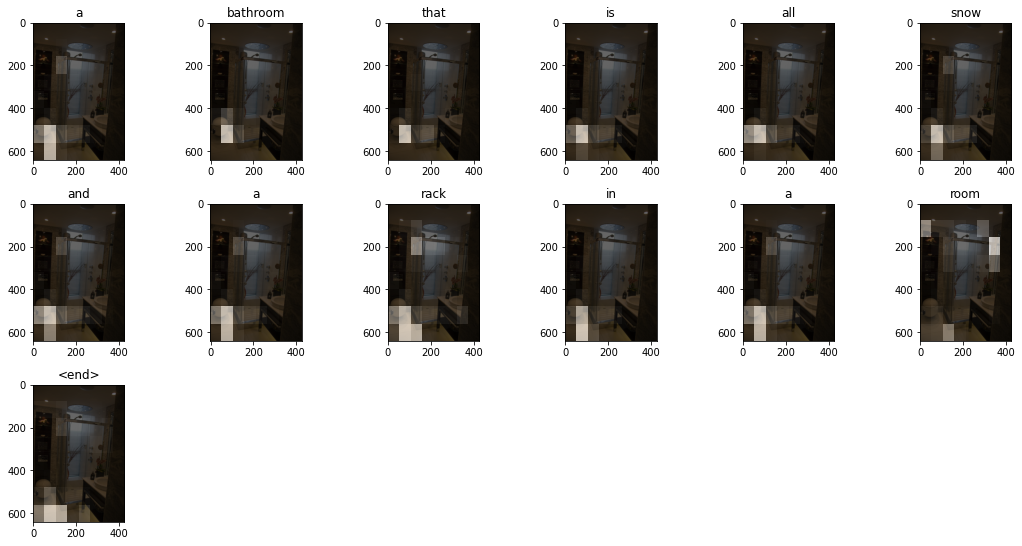

In [95]:
evaluate(img_paths_val, captions_seqs_val)